# Creating and Testing Agent Workflows for FPL Gaffer

## FPL Data Collector Agent

#### State

In [ ]:
from typing import Dict, List, Optional, Any
from pydantic import BaseModel
from datetime import datetime

In [ ]:
# Define the workflow state
class WorkflowState(BaseModel):
    gameweek: int
    gameweek_deadline: datetime
    fpl_api_data: Dict[str, Any] = {}
    news_searcher_data: List[str] = []
    user_data: Dict = {}
    recommendations: List[Dict] = []
    generated_message: str = ""
    errors: List[str] = []


#### Tools

In [ ]:
# FPL API tool
import httpx
from typing import Dict

class FPLOfficialAPI:
    def __init__(self):
        self.base_url = "https://fantasy.premierleague.com/api"
        self.session = httpx.AsyncClient()

    async def get_bootstrap_data(self) -> Dict:
        try:
            response = await self.session.get("{}/bootstrap-static/".format(self.base_url))
            response.raise_for_status()
            return response.json()
        except Exception as e:
            print("Error fetching bootstrap data: {}".format(e))
            return {}

    async def get_gameweek_data(self) -> Dict:
        bootstrap_data = await self.get_bootstrap_data()
        if not bootstrap_data:
            return {}

        # Get current gameweek from bootstrap data
        current_gw = None
        for gw in bootstrap_data.get("events", []):
            if gw["is_current"]:
                current_gw = gw
                break

        # Get fixtures for the current gameweek
        fixtures = await self.get_fixtures()
        if not fixtures:
            return {}

        # Filter fixtures for the current gameweek
        current_gw_fixtures = [
            fixture for fixture in fixtures if fixture.get("event") == current_gw.get("id")
        ] if current_gw else []

        return {
            "gameweek": current_gw.get("id") if current_gw else None,
            "deadline": current_gw.get("deadline_time") if current_gw else None,
            "finished": current_gw.get("finished") if current_gw else False,
            "fixtures": current_gw_fixtures
        }

    async def get_fixtures(self) -> Dict:
        try:
            response = await self.session.get("{}/fixtures/".format(self.base_url))
            response.raise_for_status()
            return response.json()
        except Exception as e:
            print("Error fetching fixtures: {}".format(e))
            return {}


In [ ]:
# FPL News Searcher tool
import os
from tavily import TavilyClient
from typing import Optional, List, Dict
from langchain.schema import Document
from langchain_community.document_loaders import UnstructuredURLLoader
from asyncio import to_thread
from dotenv import load_dotenv

#  Load environment variables
_ = load_dotenv()


class FPLNewsSearcher:
    # Required env variables for FPL news searcher
    REQUIRED_ENV_VARS = ["TAVILY_API_KEY"]

    def __init__(self):
        self.client =  TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))
        self.news_docs: List[Document] = []

    def search_news(self) -> List[Document]:
        self._search_injury_news()
        self._search_team_news()
        self._search_fpl_news()
        return self.news_docs

    def _search(self, query: str) -> Dict:
        return self.client.search(
            query=query,
            search_depth="advanced",
            max_results=3,
            topic="news",
            include_raw_content=False
        )

    def _search_and_load_docs(self, queries: List[str], category: str = None) -> None:
        for query in queries:
            # Get the tavily api search results for each query
            response = self._search(query)

            # Get the urls from the search results
            urls = [result["url"] for result in response.get("results", []) if "url" in result]

            if urls:
                # Fetch and parse the content from each URL
                loader = UnstructuredURLLoader(urls=urls)
                loaded_docs = to_thread(loader.load)

                # Update documents' metadata
                for i, d in enumerate(loaded_docs):
                    d.metadata.update({
                        "source": urls[i],
                        "query": query,
                        "category": category
                    })

                # Extend the news_docs list with the new documents
                self.news_docs.extend(loaded_docs)

    def _search_injury_news(self) -> None:
        self._search_and_load_docs([
            "Premier League team news injury reports press conference updates",
        ], category="injury")

    def _search_team_news(self) -> None:
        self._search_and_load_docs([
            "Fantasy Premier League benching risks and squad news",
            "FPL rotation risk players starting XI updates",
        ], category="team")

    def _search_fpl_news(self) -> None:
        self._search_and_load_docs([
            "FPL Scout selection and transfer recommendations latest",
            "FPL Scout best tips and advice latest",
            "FPL captain picks latest expert analysis"
        ], category="fpl")


#### Agents

In [ ]:
# Data collector agent
class FPLDataCollector:
    pass

In [ ]:
# Data analysis agent
class FPLDataAnalyzer:
    pass

#### Nodes

In [ ]:
## Nodes

#### Graph

# Demo Workflow Graph

In [3]:
from pydantic import BaseModel, Field
from typing import Dict, List
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

In [9]:
class WorkflowState(BaseModel):
    fpl_api_data: Dict = Field(default_factory=dict)
    news_search_data: str = ""
    insights: str = ""

workflow_graph = StateGraph(WorkflowState)

In [10]:
# Defining demo nodes
def fetch_fpl_data(state: WorkflowState) -> WorkflowState:
    state.fpl_api_data.update({
        "gameweek": 1,
        "deadline": "2025-08-15T17:30:00Z",
        "finished": False
    })

    return state

def search_news(state: WorkflowState) -> WorkflowState:
    state.news_search_data += "News search results from news searcher tool."

    return state

def synthesize_data(state: WorkflowState) -> WorkflowState:
    fpl_data = state.fpl_api_data
    news_data = state.news_search_data
    state.insights += f"These are the insights for GW {fpl_data.get('gameweek', '?')} combined with {news_data}"

    return state


In [11]:
# Add nodes to the graph
workflow_graph.add_node("fetch_fpl_data", fetch_fpl_data)
workflow_graph.add_node("search_news", search_news)
workflow_graph.add_node("synthesize_data", synthesize_data)

# Add edges
workflow_graph.add_edge(START, "fetch_fpl_data")
workflow_graph.add_edge("fetch_fpl_data", "search_news")
workflow_graph.add_edge("search_news", "synthesize_data")
workflow_graph.add_edge("synthesize_data", END)

In [12]:
# Compile the graph
workflow_graph_builder = workflow_graph.compile()

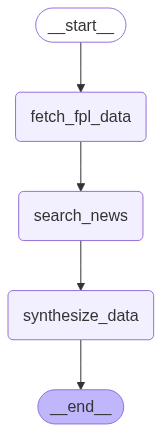

In [13]:
# Display the graph
display(Image(workflow_graph_builder.get_graph().draw_mermaid_png()))